Proyecto **COMPRESIÓN DE IMÁGENES**

Integrantes:

*   Park Diana
*   Perez de la Rosa Franco


Código para comprimir una imagen color raw a jpeg

In [ ]:
!pip install rawpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.3 MB/s eta 0:00:00


Aplicando filtro pasa-bajo en imagen RAW y comprimiendo a JPEG:


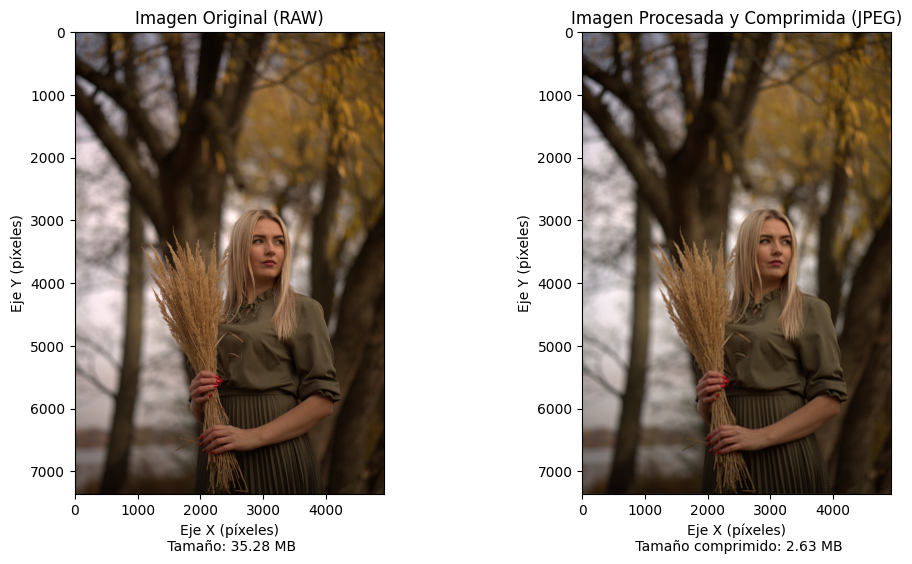

In [ ]:
# Inclusión de librerías necesarias para el procesamiento de imágenes y matemáticas
import cv2  # Librería OpenCV para procesamiento de imágenes
import numpy as np  # Librería para operaciones con matrices y álgebra lineal
import matplotlib.pyplot as plt  # Librería para gráficos y visualización
import rawpy  # Librería para leer imágenes RAW
from math import sqrt  # Importación de la función sqrt (raíz cuadrada) desde math
import os  # Librería para interactuar con el sistema operativo, en este caso, obtener tamaños de archivos

# Función para calcular la distancia euclidiana entre dos puntos en el plano
def distancia(p1, p2):
    return sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)  # Fórmula de distancia Euclidiana

# Función para implementar un filtro pasa-bajo que elimina las frecuencias más altas
def FiltroPasaBajo(D0, imgShape):
    base = np.zeros(imgShape[:2])  # Crear una matriz de ceros del tamaño de la imagen (solo con dimensiones de filas y columnas)
    rows, cols = imgShape[:2]  # Extraer las dimensiones de la imagen (filas y columnas)
    center = (rows / 2, cols / 2)  # Calcular el centro de la imagen
    for x in range(cols):  # Iterar sobre las columnas
        for y in range(rows):  # Iterar sobre las filas
            if distancia((y, x), center) < D0:  # Si la distancia de un punto al centro es menor que D0
                base[y, x] = 1  # Asignar valor 1 a los puntos dentro del radio de corte (baja frecuencia)
    return base  # Retornar la máscara de filtro pasa-bajo

# Función principal para procesar la imagen RAW, aplicar el filtro pasa-bajo y comprimir a formato JPEG
def procesar_imagen_raw(img_path, D0, filtro):
    # Leer la imagen RAW usando la librería rawpy
    with rawpy.imread(img_path) as raw:
        # Procesar la imagen RAW sin aplicar cambios en el balance de blancos
        img = raw.postprocess(user_wb=None, no_auto_bright=True, use_camera_wb=True)
        # Convertir la imagen de formato RGB (rawpy) a BGR (formato utilizado por OpenCV)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Separar la imagen en sus tres canales de color (BGR)
    canales = cv2.split(img)

    canales_procesados = []  # Lista vacía para almacenar los canales procesados
    for canal in canales:  # Iterar sobre cada uno de los canales de color (B, G, R)
        # Aplicar la Transformada Rápida de Fourier 2D (FFT) para obtener el espectro de frecuencias
        img_c2 = np.fft.fft2(canal)

        # Centrar el espectro de las frecuencias en el punto medio de la imagen
        img_c3 = np.fft.fftshift(img_c2)

        # Aplicar el filtro pasa-bajo al espectro de frecuencias
        filtro_aplicado = filtro(D0, img_c3.shape)  # Llamar a la función de filtro pasa-bajo con el radio D0
        img_filtrada = img_c3 * filtro_aplicado  # Filtrar el espectro multiplicando por el filtro

        # Reconstruir el espectro de frecuencias desplazado al centro
        img_c4 = np.fft.ifftshift(img_filtrada)

        # Reconstruir la imagen a partir del espectro de frecuencias filtrado usando la Transformada Inversa de Fourier
        img_c5 = np.fft.ifft2(img_c4)
        # Tomar el valor absoluto de la imagen reconstruida (eliminando la parte imaginaria)
        # Normalizar la imagen al rango [0, 255] antes de convertirla a uint8
        img_c5 = np.abs(img_c5)
        max_original = np.max(img_c5)  # Obtener el valor máximo de la imagen procesada
        # Normalizar si la imagen está fuera del rango [0, 255]
        min_val = np.min(img_c5)
        max_val = np.max(img_c5)
        if max_val > 255:
            img_c5 = (img_c5 - min_val) / (max_val - min_val) * 255  # Escalar la imagen al rango [0, 255]

        # Convertir la imagen normalizada a tipo de dato uint8 (valores enteros de 0 a 255)
        img_c5 = img_c5.astype(np.uint8)

        # Agregar el canal procesado a la lista de canales procesados
        canales_procesados.append(img_c5)

    # Unir los tres canales de color procesados para obtener la imagen final
    img_procesada = cv2.merge(canales_procesados)

    # Guardar la imagen procesada como archivo JPEG
    comprimida_path = 'imagen_comprimida.jpg'
    cv2.imwrite(comprimida_path, img_procesada)  # Guardar la imagen comprimida en formato JPEG

    # Obtener el tamaño de la imagen original y comprimida en megabytes
    original_size = os.path.getsize(img_path) / (1024 * 1024)  # Tamaño de la imagen original en MB
    comprimida_size = os.path.getsize(comprimida_path) / (1024 * 1024)  # Tamaño de la imagen comprimida en MB

    # Calcular el porcentaje de reducción del tamaño de la imagen
    reduccion = (1 - comprimida_size / original_size) * 100

    # Mostrar las imágenes original y procesada en gráficos
    plt.figure(figsize=(12, 6))

    # Mostrar la imagen original en el primer gráfico
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convertir a RGB para mostrar con matplotlib
    plt.title("Imagen Original (RAW)")  # Título del gráfico
    plt.xlabel(f"Eje X (píxeles)\n Tamaño: {original_size:.2f} MB")  # Etiqueta del eje X y tamaño original de la imagen
    plt.ylabel("Eje Y (píxeles)")  # Etiqueta del eje Y

    # Mostrar la imagen procesada y comprimida en el segundo gráfico
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_procesada.astype(np.uint8), cv2.COLOR_BGR2RGB))  # Convertir a RGB para mostrar
    plt.title("Imagen Procesada y Comprimida (JPEG)")  # Título del gráfico
    plt.xlabel(f"Eje X (píxeles)\n Tamaño comprimido: {comprimida_size:.2f} MB")  # Etiqueta del eje X y tamaño comprimido de la imagen
    plt.ylabel("Eje Y (píxeles)")  # Etiqueta del eje Y

    # Mostrar los gráficos
    plt.show()

    # Mostrar el tamaño de las imágenes y el porcentaje de reducción en la consola
    print(f"Tamaño de la imagen original: {original_size:.2f} MB")
    print(f"Tamaño de la imagen comprimida: {comprimida_size:.2f} MB")
    print(f"Reducción del tamaño: {reduccion:.2f}%")

# Ejecución del código con la ruta de la imagen RAW y los parámetros para el filtro pasa-bajo
imagen_path = "/content/img2.arw"  # Ruta del archivo de imagen RAW (reemplazar con la ruta adecuada)

D0_bajo = 150 # Radio de corte para el filtro pasa-bajo (ajustable)

print("Aplicando filtro pasa-bajo en imagen RAW y comprimiendo a JPEG:")
# Llamada a la función principal para procesar la imagen con el filtro pasa-bajo y comprimirla
procesar_imagen_raw(imagen_path, D0_bajo, FiltroPasaBajo)


Banco de imágenes RAW gratuitas: https://www.signatureedits.com/free-raw-photos/